<a href="https://colab.research.google.com/github/ovieimara/ITNPAI1/blob/master/AI1_practical3_1_BERTopic_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##This exercise is about Topic identification. You will be comparing two methods. One is Latent Dirichlet Analysis (mentioned in the lecture) and the other one is BERTopic. LDA is a Bayesian clustering method while BERTopic is based on embeddings.

In [3]:
%%capture
!pip install bertopic umap-learn hdbscan gensim scikit-learn nltk

### We'll be using the natural language tool kit (https://www.nltk.org/) to get sample texts (Reuters news) as well as basic preprocessing features for punctuation and removing stopwords.

In [1]:
import nltk
nltk.download("reuters")
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

###First we generate a random sample of 100 documents from the Reuters dataset. It will be stored in the `texts` variable. For LDA we need to *tokenize* (no need to do that for BERTopic as it is integrated).

In [4]:
import numpy as np
import random
import umap
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import reuters, stopwords
from gensim.models import LdaModel
from gensim.corpora import Dictionary

# Load stopwords
stop_words = set(stopwords.words("english"))

sample_docs = random.sample(reuters.fileids(), 100)

#Restart here if you are regenerating `sample_docs` from the bottom of this Notebook

In [5]:
texts = [
    " ".join([word.lower() for word in reuters.words(doc) if word.isalpha() and word.lower() not in stop_words])
    for doc in sample_docs
]

# Tokenize for LDA
tokenized_texts = [text.split() for text in texts]

### BERTopics uses embeddings hence we will need UMAP for dimensionality reduction so we can identify a set of topics. Note that BERTopic identifies candidate topics from relationship between words. It does not automatically find a 'label' for the topics hence the `Name` given below to topics are arbitrary.

In [6]:
# Reduce dimensionality with UMAP
umap_model = umap.UMAP(n_components=5, random_state=42, low_memory=True)

# Set up CountVectorizer with min_df to filter out words that occur in too few documents
vectorizer_model = CountVectorizer(min_df=2)

# Initialize BERTopic with UMAP, min_topic_size, and vectorizer_model
topic_model = BERTopic(umap_model=umap_model, vectorizer_model=vectorizer_model, min_topic_size=3)

# Fit BERTopic to your texts
topics, probs = topic_model.fit_transform(texts)

# Get topic distributions
bertopic_topics = topic_model.get_topic_info()
print(bertopic_topics.head())  # Check BERTopic output

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

   Topic  Count                            Name  \
0     -1     17           -1_said_mln_dlrs_year   
1      0     32              0_cts_net_shr_loss   
2      1     28               1_said_lt_pct_inc   
3      2     13           2_stg_bank_pct_market   
4      3      6  3_demand_economy_domestic_said   

                                      Representation  \
0  [said, mln, dlrs, year, bpd, prices, oil, outp...   
1  [cts, net, shr, loss, mln, dlrs, year, lt, not...   
2  [said, lt, pct, inc, company, group, bid, shar...   
3  [stg, bank, pct, market, mln, february, januar...   
4  [demand, economy, domestic, said, rise, trade,...   

                                 Representative_Docs  
0  [treasury foreign reserves jordan priorities j...  
1  [bergen brunswig corp lt bbca qtr feb net shr ...  
2  [five groups apply buy french telephone group ...  
3  [u k money market given mln stg help bank engl...  
4  [british farm minister attacks subsidies farm ...  


###Now let's use LDA on the same set (texts). We need to remove stopwords as well. We set the number of candidate topics `num_topics` to be the same as the number of `topics` identified previously by BERTopics

In [7]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from nltk.corpus import stopwords

# Load stopwords (can replace with a custom list)
stop_words = set(stopwords.words("english"))

# Remove stopwords from tokenized texts
tokenized_texts_cleaned = [[word for word in text if word.lower() not in stop_words] for text in tokenized_texts]

# Create dictionary and corpus
dictionary = Dictionary(tokenized_texts_cleaned)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts_cleaned]

# Train LDA
num_topics = len(set(topics))  # Match BERTopic's topic count
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10, random_state=42)


### Let's look at the words that are associated with each candidate topic.

#Example:
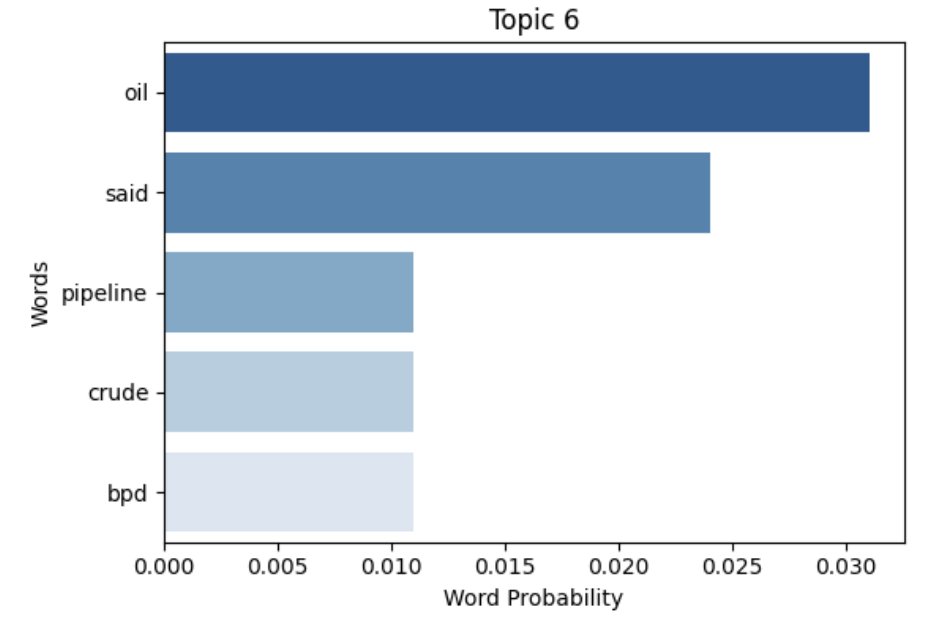

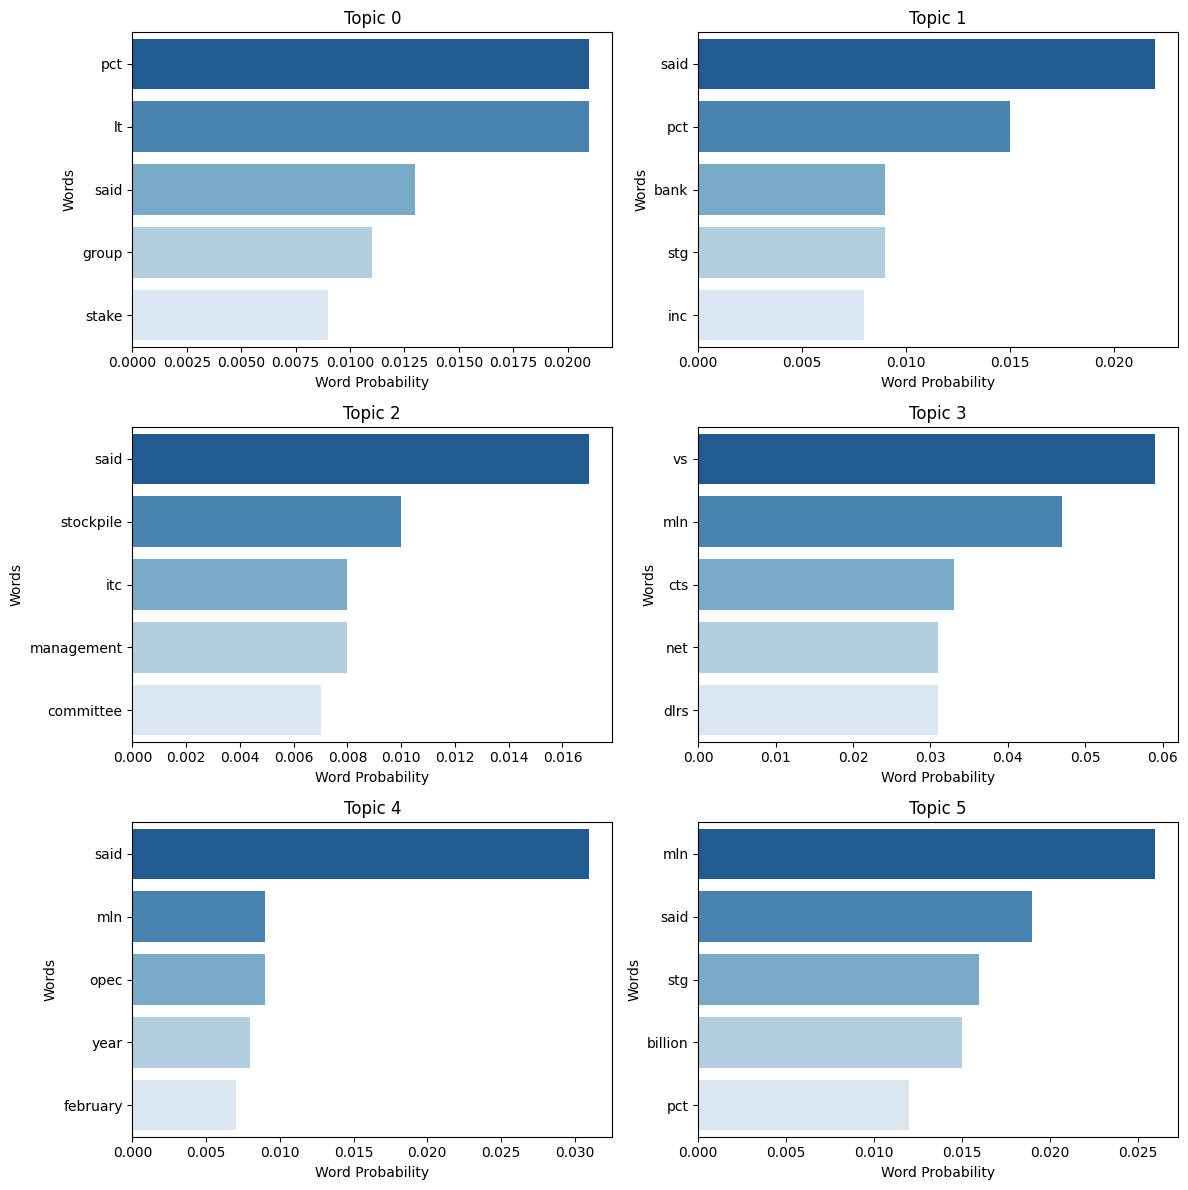

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract top words for each topic
def get_lda_top_words(lda_model, num_words=5):
    topics_dict = {}
    for topic_idx, topic in enumerate(lda_model.print_topics(num_topics=-1, num_words=num_words)):
        words_probs = topic[1].split(" + ")
        words_probs = [word.split("*") for word in words_probs]
        words = [w[1].strip('"') for w in words_probs]
        probs = [float(w[0]) for w in words_probs]
        topics_dict[topic_idx] = {"Words": words, "Probs": probs}
    return topics_dict

# Convert to DataFrame
topics_dict = get_lda_top_words(lda_model)
lda_topics_df = pd.DataFrame.from_dict(topics_dict, orient="index")

# Plot all topics in a grid layout
def plot_all_lda_topics(lda_topics_df, num_cols=2):
    num_topics = len(lda_topics_df)
    num_rows = (num_topics // num_cols) + (num_topics % num_cols > 0)  # Grid calculation

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 4))
    axes = axes.flatten()  # Flatten for easy indexing

    for topic_id, ax in enumerate(axes[:num_topics]):
        sns.barplot(x=lda_topics_df.loc[topic_id, "Probs"], y=lda_topics_df.loc[topic_id, "Words"], palette="Blues_r", ax=ax)
        ax.set_title(f"Topic {topic_id}")
        ax.set_xlabel("Word Probability")
        ax.set_ylabel("Words")

    # Hide unused subplots if topics < grid size
    for ax in axes[num_topics:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Call the function to plot all topics
plot_all_lda_topics(lda_topics_df, num_cols=2)


### same thing for BERTopic

#Example:
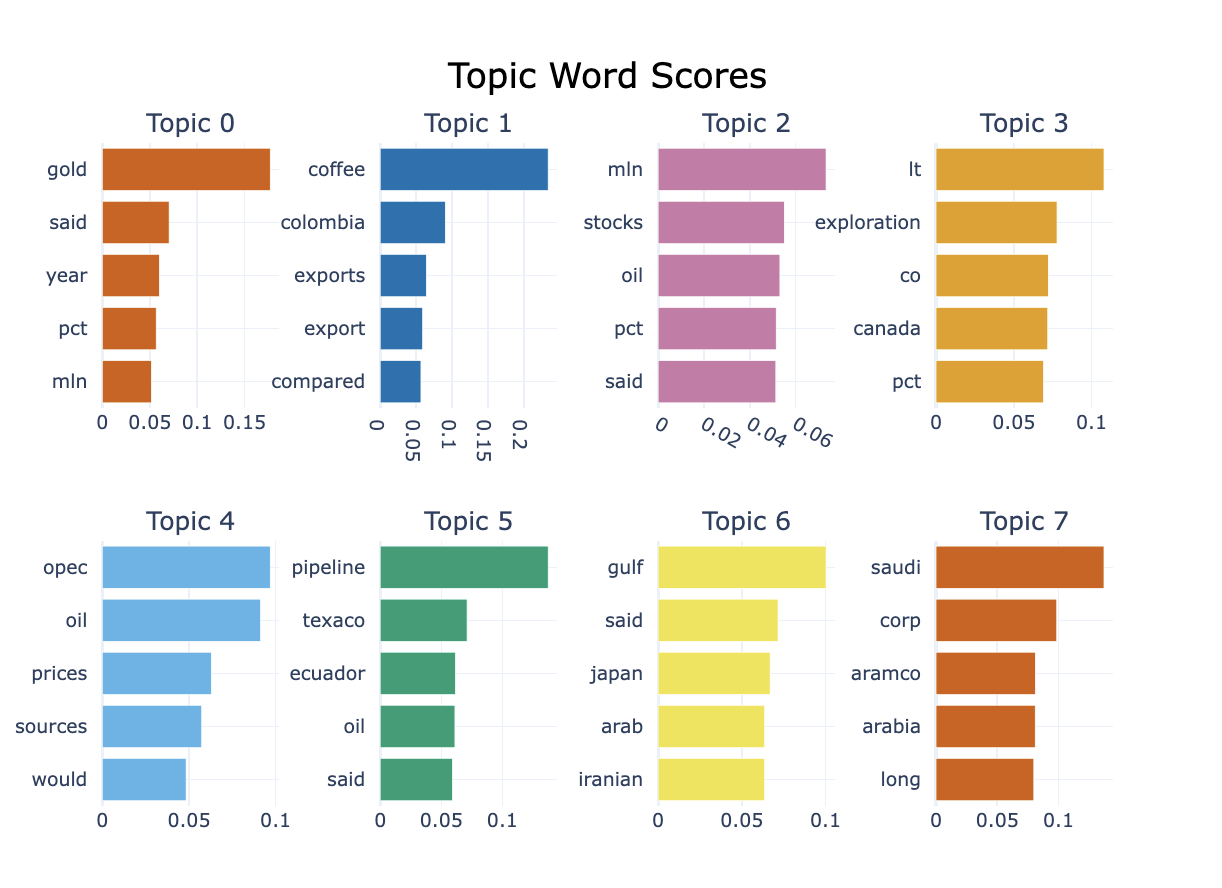

In [13]:
from gensim.models.coherencemodel import CoherenceModel

num_words = 10  # Number of words per topic
bertopic_word_lists = [
    [word for word, _ in topic_model.get_topic(i)][:num_words] # Slice to get top N words
    for i in range(len(set(topics))) if i != -1 and topic_model.get_topic(i)
]


from bertopic import BERTopic
import umap

# you can try different values for top_n_topics to see what works best
topic_model.visualize_hierarchy().update_layout(width=800, height=600)
topic_model.visualize_barchart().update_layout(width=800, height=600)

### there are also coherence scores that measure the quality of topic extractions by both methods

In [14]:
# LDA coherence
lda_coherence = CoherenceModel(model=lda_model, texts=tokenized_texts, dictionary=dictionary, coherence="c_v")
lda_coh_score = lda_coherence.get_coherence()

# BERTopic coherence
bertopic_coherence = CoherenceModel(topics=bertopic_word_lists, texts=tokenized_texts, dictionary=dictionary, coherence="c_v")
bertopic_coh_score = bertopic_coherence.get_coherence()

print(f"LDA Coherence Score: {lda_coh_score}")
print(f"BERTopic Coherence Score: {bertopic_coh_score}")

LDA Coherence Score: 0.38075995885821506
BERTopic Coherence Score: 0.4616624051540773


### The Reuters datasets comes with topic categorisation. Let's look at how 'accurate' labels for BERTopic and LDA are to the default ones
Because neither BERTopic nor LDA provide default topic labels, these need to be calculated based on the most probable labels.

In [15]:
from nltk.corpus import reuters

# Get document categories as ground truth labels
true_labels = [reuters.categories(doc)[0] for doc in sample_docs]  # Taking the first category if multiple

## We'll be using the ARI score to compare the clustering to the ground truth reuters categories. Check its definition here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html

In [16]:
from sklearn.metrics import adjusted_rand_score

# Compute ARI for BERTopic
ari_bertopic = adjusted_rand_score(true_labels, topics)

# Compute ARI for LDA
lda_topic_labels = [max(lda_model.get_document_topics(doc), key=lambda x: x[1])[0] for doc in corpus]
ari_lda = adjusted_rand_score(true_labels, lda_topic_labels)

print(f"ARI Score - BERTopic vs Reuters: {ari_bertopic}")
print(f"ARI Score - LDA vs Reuters: {ari_lda}")

ARI Score - BERTopic vs Reuters: 0.6148548143118514
ARI Score - LDA vs Reuters: 0.32430617513565285


## How are topics distributed across the set of documents? Compare BERTopic and LDA.

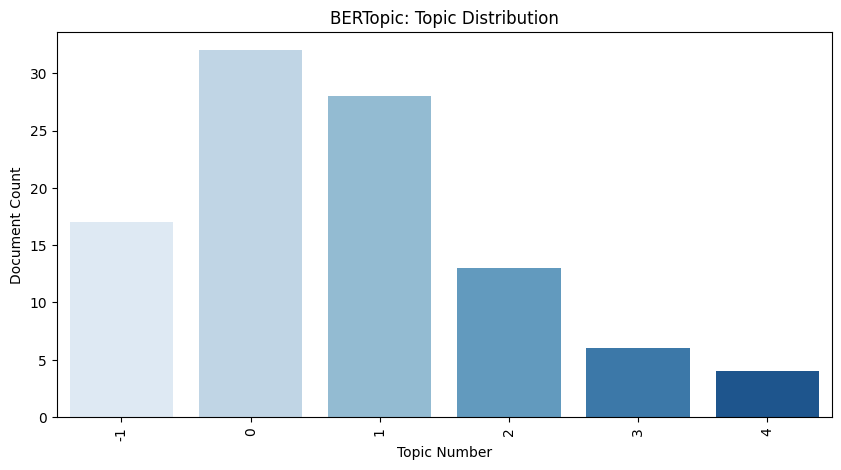

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get topic frequencies
bertopic_freqs = topic_model.get_topic_freq()
# bertopic_freqs = bertopic_freqs[bertopic_freqs.Topic != -1]  # Remove outliers

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=bertopic_freqs["Topic"], y=bertopic_freqs["Count"], palette="Blues")
plt.xlabel("Topic Number")
plt.ylabel("Document Count")
plt.title("BERTopic: Topic Distribution")
plt.xticks(rotation=90)
plt.show()


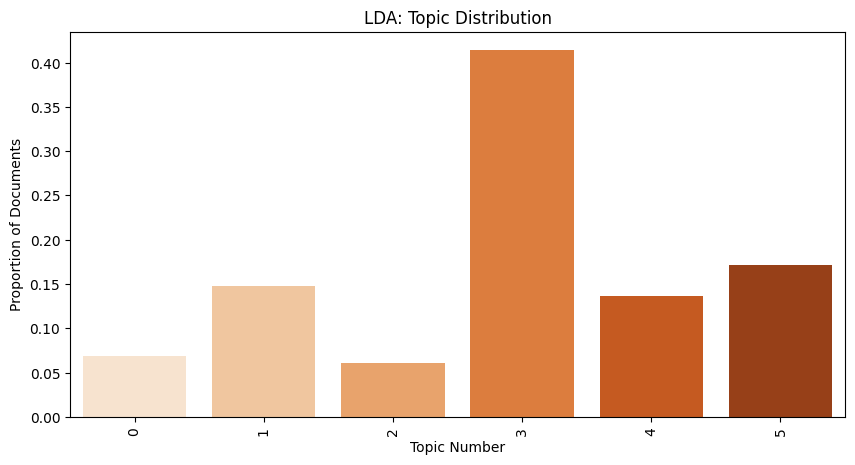

In [18]:
# Get LDA topic frequencies
lda_topic_counts = np.zeros(num_topics)

for doc in corpus:
    for topic, weight in lda_model.get_document_topics(doc):
        lda_topic_counts[topic] += weight  # Sum contributions of each topic

# Convert to percentages
lda_topic_counts /= np.sum(lda_topic_counts)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=np.arange(num_topics), y=lda_topic_counts, palette="Oranges")
plt.xlabel("Topic Number")
plt.ylabel("Proportion of Documents")
plt.title("LDA: Topic Distribution")
plt.xticks(rotation=90)
plt.show()


#You can start again by regenerating another set of 100 documents, and compare the topics and most frequent words.

##Overall BERTopic, which is a most recent methods performs better.

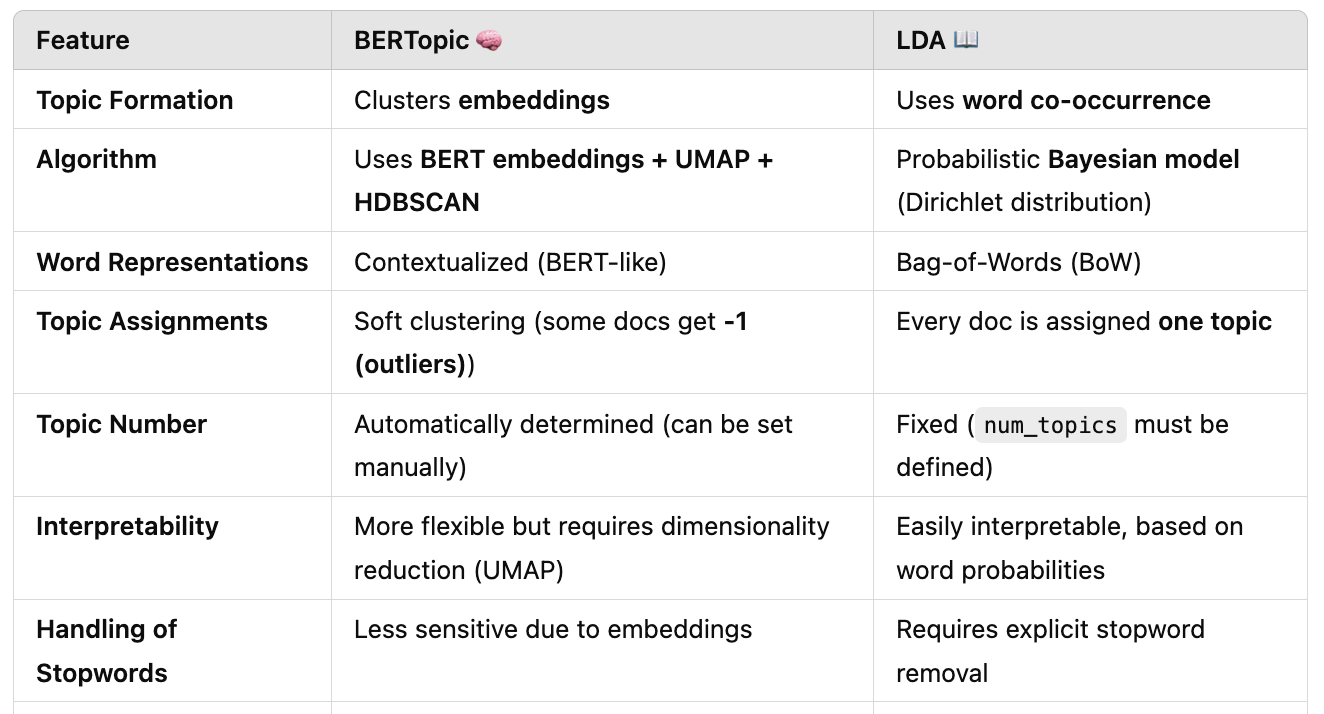

#Now you can run the same comparisons with different texts: you can either restart the notebook and get a different random set, or select specific document by numbers or specific topics.

In [19]:
# Sample Reuters documents (100 first documents)
sample_docs = reuters.fileids()[:100]  # Use 100 documents for comparison

In [20]:
# check available categories
print(reuters.categories())  # Prints all topic names

['acq', 'alum', 'barley', 'bop', 'carcass', 'castor-oil', 'cocoa', 'coconut', 'coconut-oil', 'coffee', 'copper', 'copra-cake', 'corn', 'cotton', 'cotton-oil', 'cpi', 'cpu', 'crude', 'dfl', 'dlr', 'dmk', 'earn', 'fuel', 'gas', 'gnp', 'gold', 'grain', 'groundnut', 'groundnut-oil', 'heat', 'hog', 'housing', 'income', 'instal-debt', 'interest', 'ipi', 'iron-steel', 'jet', 'jobs', 'l-cattle', 'lead', 'lei', 'lin-oil', 'livestock', 'lumber', 'meal-feed', 'money-fx', 'money-supply', 'naphtha', 'nat-gas', 'nickel', 'nkr', 'nzdlr', 'oat', 'oilseed', 'orange', 'palladium', 'palm-oil', 'palmkernel', 'pet-chem', 'platinum', 'potato', 'propane', 'rand', 'rape-oil', 'rapeseed', 'reserves', 'retail', 'rice', 'rubber', 'rye', 'ship', 'silver', 'sorghum', 'soy-meal', 'soy-oil', 'soybean', 'strategic-metal', 'sugar', 'sun-meal', 'sun-oil', 'sunseed', 'tea', 'tin', 'trade', 'veg-oil', 'wheat', 'wpi', 'yen', 'zinc']


In [22]:
# get 100 docs for specific categories
categories = ["crude", "coffee", "gold"]
docs_in_multiple_categories = reuters.fileids(categories=categories)
sample_docs = docs_in_multiple_categories[:100]
print(sample_docs)

['test/14829', 'test/14840', 'test/14842', 'test/15063', 'test/15198', 'test/15200', 'test/15230', 'test/15238', 'test/15244', 'test/15322', 'test/15329', 'test/15339', 'test/15344', 'test/15351', 'test/15357', 'test/15411', 'test/15471', 'test/15481', 'test/15520', 'test/15540', 'test/15584', 'test/15725', 'test/15737', 'test/15803', 'test/15811', 'test/15939', 'test/15964', 'test/16005', 'test/16007', 'test/16009', 'test/16040', 'test/16077', 'test/16097', 'test/16115', 'test/16149', 'test/16162', 'test/16212', 'test/16248', 'test/16279', 'test/16286', 'test/16366', 'test/16429', 'test/16438', 'test/16589', 'test/16593', 'test/16604', 'test/16607', 'test/16636', 'test/16649', 'test/16651', 'test/16658', 'test/16710', 'test/16723', 'test/16739', 'test/16762', 'test/17038', 'test/17054', 'test/17457', 'test/17478', 'test/17516', 'test/17519', 'test/17584', 'test/17618', 'test/17622', 'test/17632', 'test/17654', 'test/17658', 'test/17664', 'test/17669', 'test/17714', 'test/17750', 'test